In [63]:
import os
import cv2
import random
import imutils
import math
import numpy as np
import openpyxl
from openpyxl import Workbook
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR
from tensorflow.keras.preprocessing import image as tfimage
from trdg.generators import GeneratorFromStrings

In [5]:
ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
DATASET_PATH = f'dataset'

# type decls
cv2.Image = np.ndarray

# shows an image on ipynb
def imshow(img: cv2.Image) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Get all testing images into an array

In [6]:
images = []
for (id, filename) in enumerate(os.listdir(DATASET_PATH)):
    image = cv2.imread(f"{DATASET_PATH}/{filename}")
    images.append((filename, image))

Defines image cropper to center the text in the image

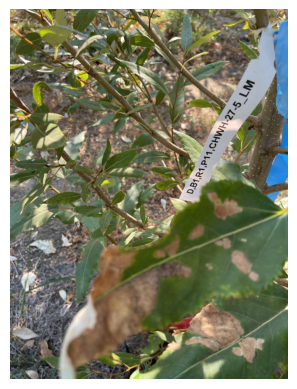

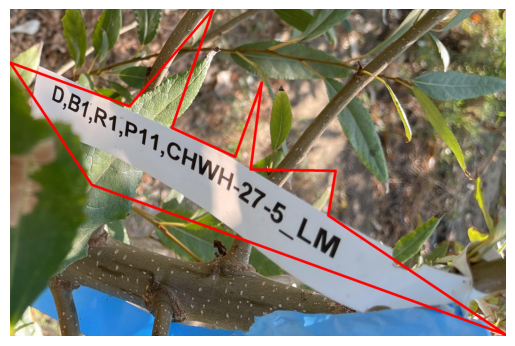

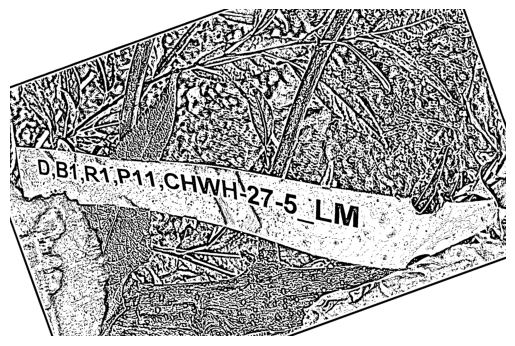

In [56]:
def process_image(img: cv2.Image, strength: int = 1) -> cv2.Image:
    gray = grayscale(img)
    blur = cv2.medianBlur(gray, 5)
    blur = tfimage.img_to_array(blur, dtype='uint8')
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, strength)
    return thresh

def get_largest_contour(img: cv2.Image):
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur,150,255,0)[1]
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    return sorted(contours, key=cv2.contourArea, reverse=True)[0]

def crop_image(img: cv2.Image, debug: bool = False) -> cv2.Image:

    if debug: imshow(img)

    big_contour = get_largest_contour(img)
    x, y, w, h = cv2.boundingRect(big_contour)
    newimg = img[y:y+h, x:x+w]

    # perform 90-deg rotation if the cropped image is wider than tall
    if h > w: newimg = np.array([[newimg[j][i] for j in reversed(range(len(newimg)))] for i in range(len(newimg[0]))])

    # get the longest line in the approximation
    newimg_big_contour = get_largest_contour(newimg)
    approx = cv2.approxPolyDP(newimg_big_contour, 0.015*cv2.arcLength(newimg_big_contour, True), True)
    simplified_approx = list(map(lambda x: tuple(x[0]), approx))
    max_line = max(zip(simplified_approx, simplified_approx[1:] + [simplified_approx[0]]), key=lambda l: (l[0][0]-l[1][0])**2 + (l[0][1]-l[1][1])**2)

    # flatten the longest line, from / to __
    y_dist = max_line[0][1]-max_line[1][1]
    x_dist = max_line[0][0]-max_line[1][0]
    angle = math.degrees(math.atan(y_dist/x_dist))

    if debug:
        drawn_contours = cv2.drawContours(newimg.copy(), [approx], -1, (0, 0, 255), 10)
        imshow(drawn_contours)
        
    newimg = imutils.rotate(newimg, angle=angle)

    return newimg

test_index = 8
img = crop_image(images[test_index][1], debug=True)
img = process_image(img)
imshow(img)

Generate synthetic data to train neural network

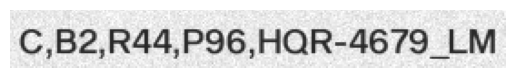

In [42]:
ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
IMG_COUNT = 100
DATA_PATH = 'synthetic-data'
IMAGES_PATH = f'{DATA_PATH}/images'

os.system(f"{'rm -rf' if os.name != 'nt' else 'rmdir /s /q'} {DATA_PATH}")
os.system(f"mkdir {DATA_PATH} {IMAGES_PATH}")
os.system(f"echo '*' > {DATA_PATH}/.gitignore")

def get_random_text():
    treatment = random.choice(['C', 'D'])
    block = f"B{random.choice(['1', '2'])}"
    row = f"R{random.randint(1, 99)}"
    position = f"P{random.randint(1, 99)}"
    
    gen_length = random.randint(2, 4)
    num_count = random.choices([1, 2, 3], weights=(70, 15, 15))[0]
    num_lengths = random.choices([1, 2, 3, 4], weights=(15, 15, 15, 55), k=num_count)

    genotype = (
        "".join([ALPHABET[random.randint(0, 25)] for _ in range(gen_length)]) + 
        f"-{'-'.join([str(random.randint(10**(i-1), 10**i-1)) for i in num_lengths])}_LM"
    )

    return ','.join([treatment, block, row, position, genotype])

# generate the new images, limiting count
generator = GeneratorFromStrings(
    [get_random_text() for _ in range(1000)],
    random_blur=True,
    random_skew=True,
    fonts=['assets/image_font.ttf']
)
i = 0
for img, lbl in generator:
    if i == IMG_COUNT: break
    img.save(f'{IMAGES_PATH}/{lbl}_{i}.png')
    i += 1

# randomly selects one image for exemplary purposes
example_img = random.choice(os.listdir(IMAGES_PATH))
imshow(cv2.imread(f"{IMAGES_PATH}/{example_img}"))

[2023/06/30 14:55:28] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[122.0, 229.0], [2213.0, 334.0], [2204.0, 492.0], [113.0, 388.0]], ('C,B2,R29,P40,GW-9813 LM', 0.9822989702224731)]]]


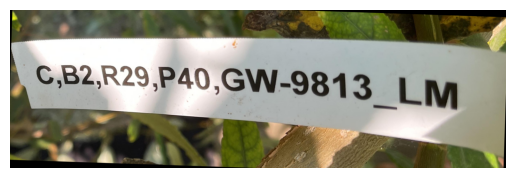

[2023/06/30 14:55:28] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[144.0, 161.0], [1672.0, 141.0], [1673.0, 245.0], [146.0, 265.0]], ('D,B1,R8,P6,BESC-415LM', 0.9266588091850281)]]]


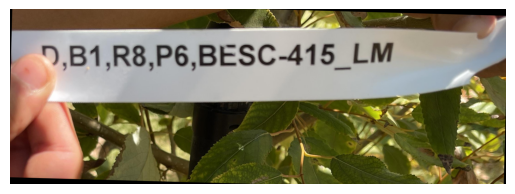

[2023/06/30 14:55:29] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/06/30 14:55:29] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[]]


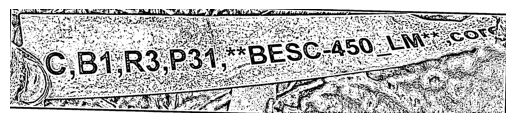

[2023/06/30 14:55:31] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[545.0, 530.0], [2146.0, 408.0], [2153.0, 508.0], [552.0, 630.0]], ('C,B2,R25,P41,BESC-358 LM', 0.9715964794158936)]]]


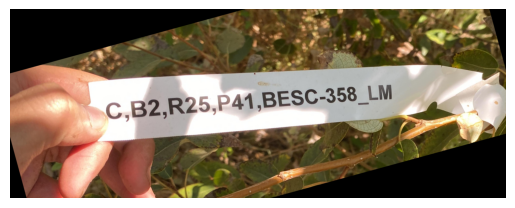

[2023/06/30 14:55:31] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[98.0, 229.0], [1523.0, 364.0], [1513.0, 462.0], [88.0, 327.0]], ('C.B1.R6.P10,GW-9847 LM', 0.9375556707382202)]]]


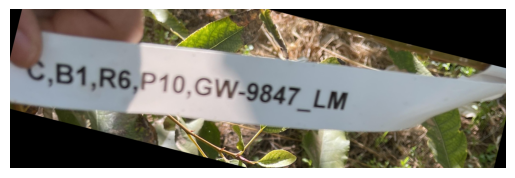

[2023/06/30 14:55:32] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[73.0, 375.0], [2180.0, 411.0], [2177.0, 555.0], [70.0, 519.0]], ('D,B1,R6,P33,BESC-134LM', 0.9708990454673767)]]]


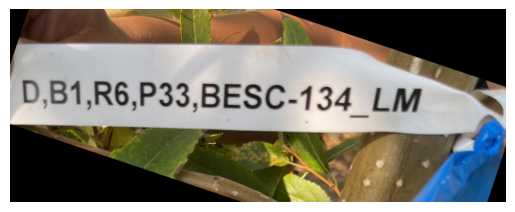

[2023/06/30 14:55:34] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/06/30 14:55:34] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[164.0, 865.0], [2054.0, 886.0], [2052.0, 1044.0], [162.0, 1023.0]], ('C,Bz,R32,P53,BESC-207', 0.9565902948379517)], [[[2056.0, 927.0], [2324.0, 947.0], [2315.0, 1069.0], [2047.0, 1049.0]], ('LM', 0.8878271579742432)]]]


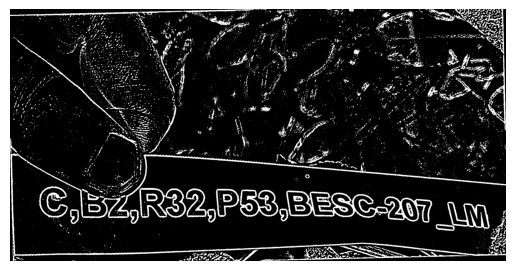

[2023/06/30 14:55:35] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[[[[946.0, 465.0], [1084.0, 515.0], [1007.0, 734.0], [870.0, 684.0]], ('MP', 0.7289841175079346)]]]


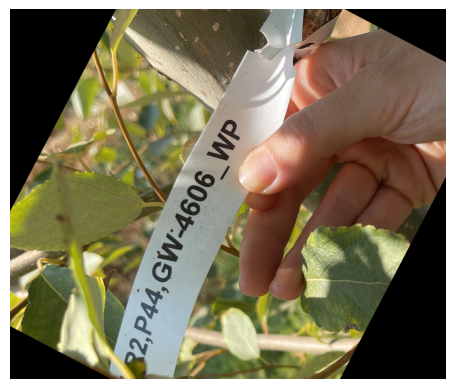

[2023/06/30 14:55:37] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/06/30 14:55:38] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[[]]


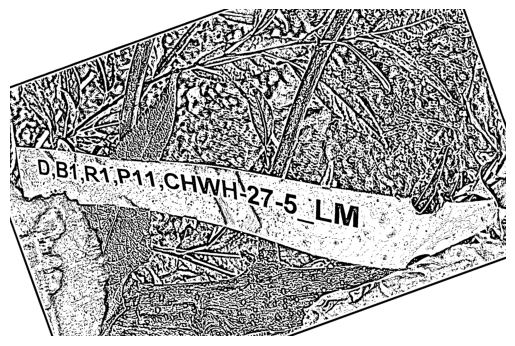

In [62]:
OCR = PaddleOCR(user_angle_cls=True, lang='en', show_log=False, rotation=True)
cropped_images = map(lambda x: crop_image(x[1]), images)
for image in cropped_images:
    if (text:=OCR.ocr(image)) == [[]]:
        bw_image = process_image(image, strength=-2)
        if (text:=OCR.ocr(bw_image)) == [[]]:
            wb_image = process_image(image, strength=1)
            image = wb_image
        else: image = bw_image
    print(text)
    imshow(image)

In [64]:
EXAMPLE_DATA = [
    {
        'filename': 'example1.png', 
        'treatment': 'C', 
        'block': '1', 
        'row': '54', 
        'position': '12', 
        'genotype': 'BESC-4590_LM'
    },
    {
        'filename': 'example2.png', 
        'treatment': 'D', 
        'block': '2', 
        'row': '23', 
        'position': '10', 
        'genotype': 'BESC-4230_LM'
    }
]

def make_sheet(data, excel_file):
    wb = Workbook()
    worksheet = wb.active
    
    # For writing the Header Rows on Excel
    headers = [*data[0].keys()]
    worksheet.append(headers)

    # For writing the data rows for each image in the dataset
    for item in data:
        rows = [item[header] for header in headers]
        worksheet.append(rows)

    wb.save(excel_file)
        
make_sheet(EXAMPLE_DATA, 'a.xlsx')

In [1]:
print("Did the change work")

Did the change work
